In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 9.8 MB/s eta 0:00:00


In [3]:
import cv2 as cv
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [6]:
img = cv.imread("/content/drive/MyDrive/face_recognition/dataset/Debanandan/IMG20230605185133~2.jpg")
# opencv BGR channel format and plt reads images as RGB channel format

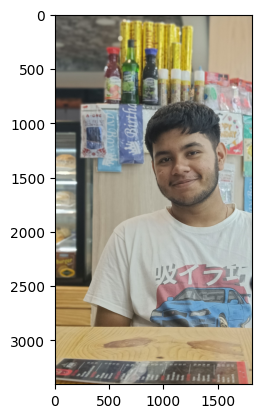

In [7]:
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img) # RGB

In [8]:
from mtcnn.mtcnn import MTCNN

detector = MTCNN()
results = detector.detect_faces(img)

1/1 [==============================] - 0s 299ms/step


In [9]:
results

[{'box': [876, 1040, 600, 683],
  'confidence': 0.9999666213989258,
  'keypoints': {'left_eye': (1013, 1333),
   'right_eye': (1269, 1272),
   'nose': (1133, 1440),
   'mouth_left': (1072, 1571),
   'mouth_right': (1310, 1521)}}]

In [10]:
x,y,w,h = results[0]['box']

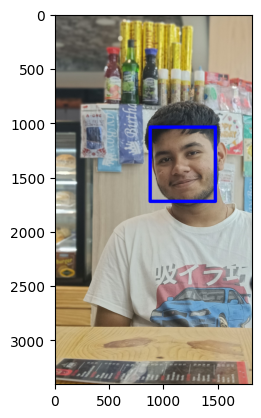

In [11]:
img = cv.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 30)
plt.imshow(img)

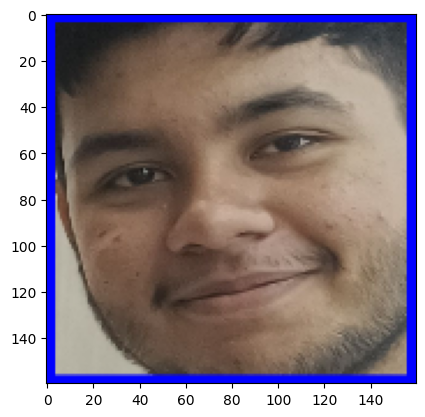

In [12]:
my_face = img[y:y+h, x:x+w]
#Facenet takes as input 160x160
my_face = cv.resize(my_face, (160,160))
plt.imshow(my_face)

array([[[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       ...,

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]]], dtype=uint8)
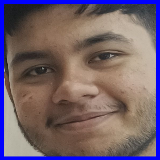

In [13]:
my_face

# Automate the preprocessing


In [17]:
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160,160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()


    def extract_face(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        x,y,w,h = self.detector.detect_faces(img)[0]['box']
        x,y = abs(x), abs(y)
        face = img[y:y+h, x:x+w]
        face_arr = cv.resize(face, self.target_size)
        return face_arr


    def load_faces(self, dir):
        FACES = []
        for im_name in os.listdir(dir):
            try:
                path = dir + im_name
                single_face = self.extract_face(path)
                FACES.append(single_face)
            except Exception as e:
                pass
        return FACES

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = self.directory +'/'+ sub_dir+'/'
            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]
            print(f"Loaded successfully: {len(labels)}")
            self.X.extend(FACES)
            self.Y.extend(labels)

        return np.asarray(self.X), np.asarray(self.Y)


    def plot_images(self):
        plt.figure(figsize=(18,16))
        for num,image in enumerate(self.X):
            ncols = 3
            nrows = len(self.Y)//ncols + 1
            plt.subplot(nrows,ncols,num+1)
            plt.imshow(image)
            plt.axis('off')

In [18]:
faceloading = FACELOADING("/content/drive/MyDrive/face_recognition/dataset")
X, Y = faceloading.load_classes()

1/1 [==============================] - 0s 17ms/step
Loaded successfully: 7
1/1 [==============================] - 0s 17ms/step
Loaded successfully: 9
1/1 [==============================] - 0s 29ms/step
Loaded successfully: 7
1/1 [==============================] - 0s 29ms/step
Loaded successfully: 5
1/1 [==============================] - 0s 18ms/step
Loaded successfully: 8


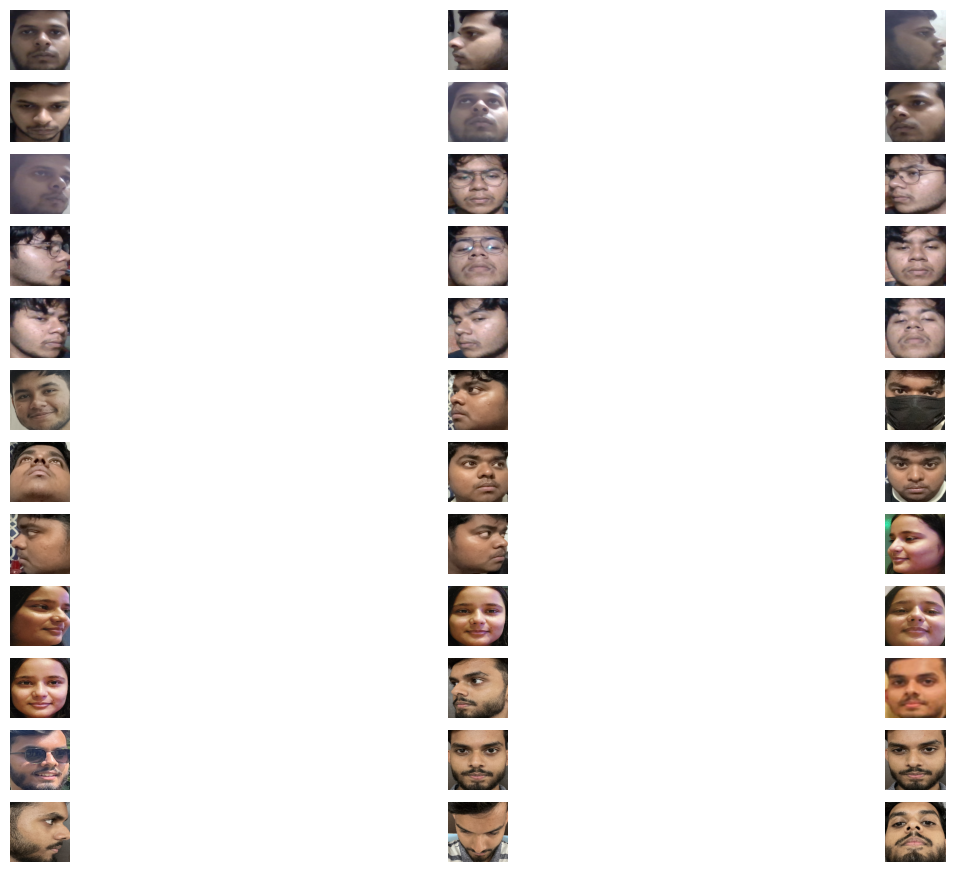

In [19]:
plt.figure(figsize=(16,12))
for num,image in enumerate(X):
    ncols = 3
    nrows = len(Y)//ncols + 1
    plt.subplot(nrows,ncols,num+1)
    plt.imshow(image)
    plt.axis('off')

# FaceNet part

In [20]:
!pip install keras-facenet

  Preparing metadata (setup.py) ... done
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10369 sha256=ceee35e6315ef97a713be7f36f9c76e4f61856e2fd6337107fe5ff9adebbaea9
  Stored in directory: /root/.cache/pip/wheels/1d/d8/a9/85cf04ea29321d2afcb82c0caaafdca9195385f9d68cbc7185
Successfully built keras-facenet


In [21]:
from keras_facenet import FaceNet
embedder = FaceNet()

def get_embedding(face_img):
    face_img = face_img.astype('float32') # 3D(160x160x3)
    face_img = np.expand_dims(face_img, axis=0)
    # 4D (Nonex160x160x3)
    yhat= embedder.embeddings(face_img)
    return yhat[0] # 512D image (1x1x512)

In [22]:
EMBEDDED_X = []

for img in X:
    EMBEDDED_X.append(get_embedding(img))

EMBEDDED_X = np.asarray(EMBEDDED_X)

1/1 [==============================] - 0s 47ms/step


In [23]:
np.savez_compressed('groupfaces_embeddings_done_5classes.npz', EMBEDDED_X, Y)

# SVM model


In [24]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

Text(0, 0.5, '0')

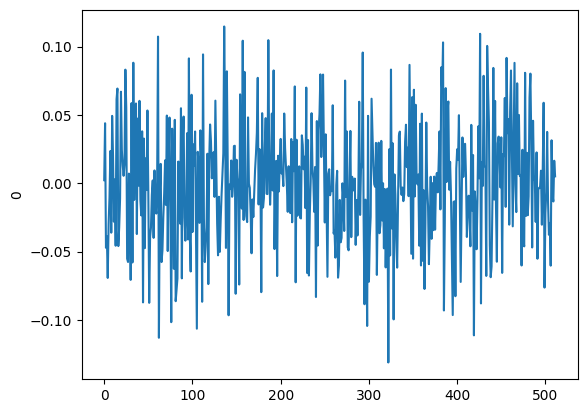

In [25]:
plt.plot(EMBEDDED_X[0])
plt.ylabel(Y[0])

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(EMBEDDED_X, Y, shuffle=True, random_state=17)

In [27]:
from sklearn.svm import SVC
model = SVC(kernel='linear', probability=True)
model.fit(X_train, Y_train)

SVC(kernel='linear', probability=True)

In [28]:
ypreds_train = model.predict(X_train)
ypreds_test = model.predict(X_test)

In [29]:
from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(Y_train, ypreds_train)
accuracy_test = accuracy_score(Y_test, ypreds_test)

print("Training Accuracy:", accuracy_train)
print("Testing Accuracy:", accuracy_test)

Training Accuracy: 1.0
Testing Accuracy: 1.0


In [30]:
t_im = cv.imread("/content/drive/MyDrive/face_recognition/astest.jpg")
t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
x,y,w,h = detector.detect_faces(t_im)[0]['box']

1/1 [==============================] - 0s 147ms/step


In [31]:
t_im = t_im[y:y+h, x:x+w]
t_im = cv.resize(t_im, (160,160))
test_im = get_embedding(t_im)

1/1 [==============================] - 0s 28ms/step


In [32]:
test_im = [test_im]
ypreds = model.predict(test_im)

In [33]:
ypreds

array([0])

In [34]:
encoder.inverse_transform(ypreds)

array(['Anurag'], dtype='<U10')

In [36]:
import pickle
#save the model
with open('svm_modelgroup_160x160.pkl','wb') as f:
    pickle.dump(model,f)

In [37]:
from sklearn.metrics import accuracy_score
# Predict probabilities for the test image
ypreds_prob = model.predict_proba(test_im)

# Get the maximum probability and corresponding class index
max_prob_index = np.argmax(ypreds_prob)
max_prob = ypreds_prob[0, max_prob_index]

# Get the predicted class label based on the index
predicted_class = encoder.inverse_transform([max_prob_index])[0]

print("Predicted Class:", predicted_class)
print("Confidence Score:", max_prob)


Predicted Class: Anurag
Confidence Score: 0.7370292178477362


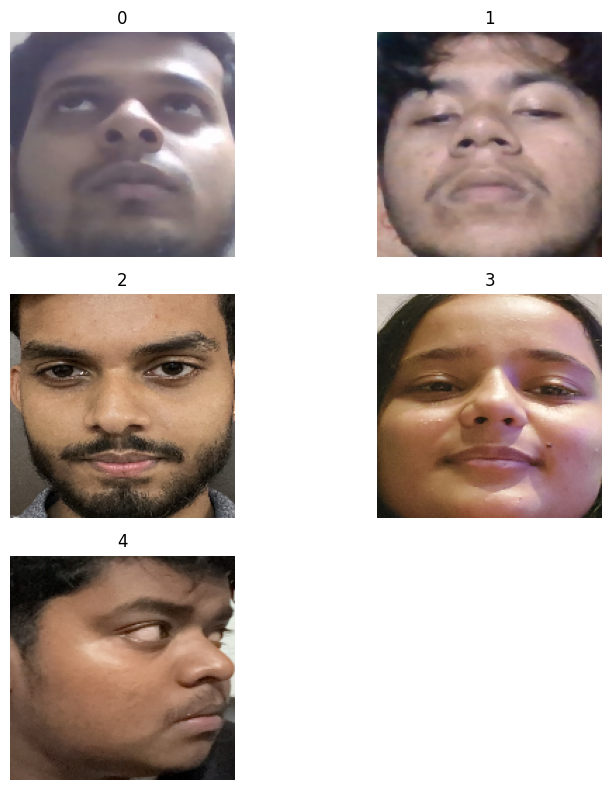

In [45]:
# Sample from each class for visualization
unique_labels = np.unique(Y)
sample_images = []
sample_labels = []
for label in unique_labels:
    label_indices = np.where(Y == label)[0]
    sample_index = np.random.choice(label_indices)
    sample_images.append(X[sample_index])
    sample_labels.append(label)

# Plot faces in a grid
plt.figure(figsize=(8, 8))
ncols = 2
nrows = len(sample_labels) // ncols + 1
for num, image in enumerate(sample_images):
    plt.subplot(nrows, ncols, num + 1)
    plt.imshow(image)
    plt.title(sample_labels[num])
    plt.axis('off')
plt.tight_layout()
plt.show()

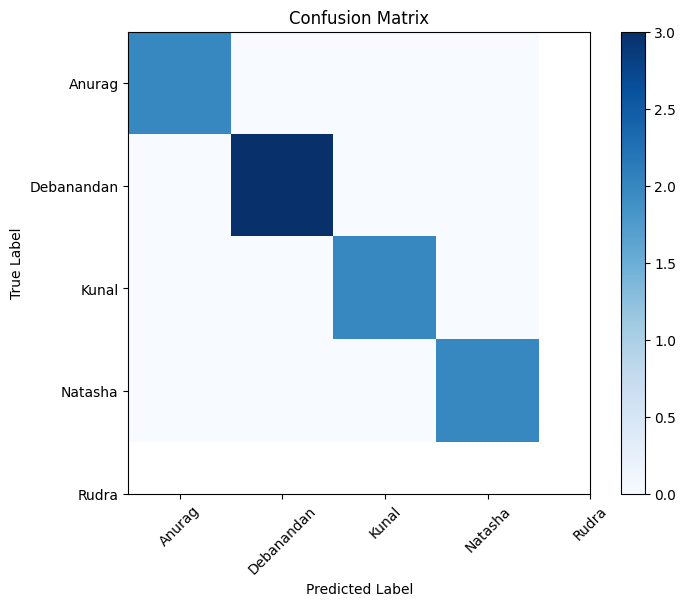

In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Convert labels to one-hot encoded format
Y_test_bin = label_binarize(Y_test, classes=np.unique(Y_test))

# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, ypreds_test)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(range(len(encoder.classes_)), encoder.classes_, rotation=45)
plt.yticks(range(len(encoder.classes_)), encoder.classes_)
plt.show()